<a href="https://colab.research.google.com/github/neuromatch/course-content-template/blob/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/course-content-template/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Meta-learning 

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]

___


# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

In this tutorial, you will examine how meta-learning separates the problem of continual learning into two stages.



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

# print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [ ]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W2D4_T3"

In [2]:
# Imports

#working with data
import numpy as np
from functools import partial

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

#utils
from tqdm import tqdm

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting functions

def plot_tasks(task_days, task_prices):
    """
    Plot the tasks' prices over time.

    Inputs:
    - task_days (list): A list of three lists, where each sub-list contains the days for a specific task.
    - task_prices (list): A list of three lists, where each sub-list contains the prices for a specific task.
    """
    sorted_first_task_days, sorted_first_task_prices = zip(*sorted(zip(task_days[0], task_prices[0]), key=lambda pair: pair[0]))
    sorted_second_task_days, sorted_second_task_prices = zip(*sorted(zip(task_days[1], task_prices[1]), key=lambda pair: pair[0]))
    sorted_third_task_days, sorted_third_task_prices = zip(*sorted(zip(task_days[2], task_prices[2]), key=lambda pair: pair[0]))

    with plt.xkcd():
      plt.plot(sorted_first_task_days, sorted_first_task_prices, label = "First Task")
      plt.plot(sorted_second_task_days, sorted_second_task_prices, label = "Second Task")
      plt.plot(sorted_third_task_days, sorted_third_task_prices, label = "Third Task")
      plt.xlabel('Day')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

In [5]:
# @title Helper functions

class UtilModel(nn.Module):
    def __init__(self, model, mean = 0, std = 1, outer_learning_rate=0.001, inner_learning_rate=0.01):
        """Super class for model; hide utility code.
        """
        super(UtilModel, self).__init__()

        self.model = self.__load_model_from_context(model)

        self.outer_learning_rate = outer_learning_rate
        self.inner_learning_rate = inner_learning_rate
        
        self.mean = mean
        self.std = std

        self.loss_fn = nn.MSELoss()

    def __load_model_from_context(self, model):
        """Load weights of the model from file or as defined architecture.
        """
        if isinstance(model, str):
            return torch.load(model)
        return model

    def deep_clone_model(self, model):
        """Create clone of the model.
        """
        clone = type(model)()
        clone.load_state_dict(model.state_dict())
        return clone

    def save_parameters(self, path):
        """Save the parameters as a state dictionary.
        """
        torch.save(self.model, path)

    def inference(self, x):
        """Implement forward pass for inference.
        """
        #apply normalization on days
        x = (x - self.mean) / self.std
        return self.model(x)

    def manual_output(self, weights, x):
        """Calculate the result of forward pass on the external values of the model parameters (weights).
        """
        for j in range(len(weights) // 2):
            kernel, bias = weights[2 * j], weights[2 * j + 1]
            if j == len(weights) // 2 - 1:
                #last layer doesn't possess ReLU activation
                return F.linear(x, kernel, bias = bias)
            else:
                x = F.relu(F.linear(x, kernel, bias = bias))

In [11]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fname = "SummerAutumnModel.pt" # The name of the file to be downloaded
url = "https://osf.io/2mc6r/download" # URL from where the file will be downloaded
expected_md5 = "9d194af9815d1a65b834d1200189c98c" # MD5 hash for verifying file integrity

if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [6]:
# @title Set device (GPU or CPU).

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [7]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [8]:
# @title Video 1: Meta-learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

In [9]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_meta_learning")

---

# Section 1: Introducing meta-learning task

In this section we are going to introduce the meta-learning approach. We will discuss its main parts and then we will focus on the definition of the task to proceed before the training. 

## Coding Exercise 1: Task space

The idea behind meta-learning is that we can "learn to learn". We aim to develop the model which is, in its desired state, able to generalize knowledge about a particular set of tasks which are similar to each other and adapt to a new task from this set in an extremely rapid way. Specifically, we aim to identify model weights such that the weight could be robustly and easily fine-tuned to create valid predictions on a specific task just in a few learning steps. It is exactly what we humans are pretty fantastic at: we perform one-shot tasks without particularly specific training.

For this, we first need to define the **task space** - the set of tasks we would like the model to be able to learn to do. Formally, we consider a distribution over tasks $p(\tau)$ that we want our model to be able to adapt to. In the $K$-shot learning setting, the model is trained to learn a new task $\tau_{i}$ drawn from $p(\tau)$ from only $K$ samples drawn from $\tau_{i}$. 

Our task space is parametrized by the tuple of parameters $(A, B, \phi, C)$ describing the relationship between day and price as following:

$$f(x) = A x^{2} + B sin(\pi x + \phi) + C$$

Thus, a particular task is tuple of assigned values. For example, $A = 0.005$, $B = 0.5$, $\phi = 0$ and $C = 0$.

You will be able to implement `FruitSupplyDataset` which enables the generation of a particular instance of the task. We will use it as extension of `torch.utils.data.Dataset` for loading data during training.

In [10]:
#define variables
days = np.arange(-26, 26 + 1/7, 1/7, dtype = np.float32)

#we are going to take only summer and autumn days
days = days[151:334]

#we will use normalization during training
days_mean, days_std = np.mean(days), np.std(days)

#define boundaries for parameters to sample from
min_A = .0005
max_A = .005

min_B = 0.05
max_B = 0.5

min_phi = 0
max_phi = np.pi

min_C = .5
max_C = 3

Please complete the missing code lines to sample parameters uniformly from their min-max range, as well as, sample `num_samples` of days for inner and outer data. As we will see later during training, inner data is used to update task-specific weights and outer data is used for calculating base weight updates.

In [24]:
class FruitSupplyDataset(Dataset):
    def __init__(self, num_epochs = 1, num_tasks = 1, num_samples = 1, days = days, also_sample_outer = True):
        """Initialize particular instance of `FruitSupplyDataset` dataset.

        Inputs:
        - num_epochs (int): Number of epochs the model is going to be trained on.
        - num_tasks (int): Number of tasks to sample for each epoch (the loss and improvement is going to be represented as sum over considered tasks).
        - num_samples (int): Number of days to sample for each task.
        - days (np.ndarray): Summer and autumn days to sample from.
        - also_sample_outer (bool): `True` if we want to sample inner and outer data (necessary for training).

        Raises:
        - ValueError: If the number of sampled days `num_samples` exceeds number of days to sample from.
        """
        
        if also_sample_outer:
            if num_samples > days.shape[0] // 2:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days divided by two as we sample inner and outer data.")
        else:
            if num_samples > days.shape[0]:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days.")
            
        #total amount of data is (2/4 x num_epochs x num_tasks x num_samples) (2/4 because -> x_inner, x_outer, y_inner, y_outer; outer is optional)
        self.num_epochs = num_epochs 
        self.num_tasks = num_tasks
        self.num_samples = num_samples
        self.also_sample_outer = also_sample_outer
        self.days = days

    def __len__(self):
        """Calculate the length of the dataset. It is obligatory for PyTorch to know in advance how many samples to expect (before training),
        thus we enforced to icnlude number of epochs and tasks per epoch in `FruitSupplyDataset` parameters."""
        
        return self.num_epochs * self.num_tasks

    def __getitem__(self, idx):
        """Generate particular instance of task with prefined number of samples `num_samples`."""

        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: complete parameters and days sampling.")
        ###################################################################

        A = np.random.uniform(..., ..., size = 1)
        B = np.random.uniform(..., ..., size = 1)
        phi = np.random.uniform(..., ..., size = 1)
        C = np.random.uniform(..., ..., size = 1)

        #`replace = False` is important flag here as we don't want repeated data
        inner_sampled_days = np.expand_dims(np.random.choice(..., size = ..., replace = False), 1)

        if self.also_sample_outer:

            #we don't want inner and outer data to overlap
            outer_sampled_days = np.expand_dims(np.random.choice(np.setdiff1d(self.days, inner_sampled_days), size = ..., replace = False), 1)
            
            return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C, outer_sampled_days, A * outer_sampled_days ** 2 + B * np.sin(np.pi * outer_sampled_days + phi) + C
            
        return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C

    def sample_particular_task(self, A, B, phi, C, num_samples):
        """Samples for the particular instance of the task defined by the tuple of parameters (A, B, phi, C) and `num_samples`."""
        
        sampled_days = np.expand_dims(np.random.choice(self.days, size = num_samples, replace = False), 1)
        return sampled_days, A * sampled_days ** 2 + B * np.sin(np.pi * sampled_days + phi) + C


In [12]:
# to_remove solution

class FruitSupplyDataset(Dataset):
    def __init__(self, num_epochs = 1, num_tasks = 1, num_samples = 1, days = days, also_sample_outer = True):
        """Initialize particular instance of `FruitSupplyDataset` dataset.

        Inputs:
        - num_epochs (int): Number of epochs the model is going to be trained on.
        - num_tasks (int): Number of tasks to sample for each epoch (the loss and improvement is going to be represented as sum over considered tasks).
        - num_samples (int): Number of days to sample for each task.
        - days (np.ndarray): Summer and autumn days to sample from.
        - also_sample_outer (bool): `True` if we want to sample inner and outer data (necessary for training).

        Raises:
        - ValueError: If the number of sampled days `num_samples` exceeds number of days to sample from.
        """

        if also_sample_outer:
            if num_samples > days.shape[0] // 2:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days divided by two as we sample inner and outer data.")
        else:
            if num_samples > days.shape[0]:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days.")
            
        #total amount of data is (2/4 x num_epochs x num_tasks x num_samples) (2/4 because -> x_inner, x_outer, y_inner, y_outer; outer is optional)
        self.num_epochs = num_epochs 
        self.num_tasks = num_tasks
        self.num_samples = num_samples
        self.also_sample_outer = also_sample_outer
        self.days = days

    def __len__(self):
        """Calculate the length of the dataset. It is obligatory for PyTorch to know in advance how many samples to expect (before training),
        thus we enforced to icnlude number of epochs and tasks per epoch in `FruitSupplyDataset` parameters."""
        
        return self.num_epochs * self.num_tasks

    def __getitem__(self, idx):
        """Generate particular instance of task with prefined number of samples `num_samples`."""

        A = np.random.uniform(min_A, max_A, size = 1)
        B = np.random.uniform(min_B, max_B, size = 1)
        phi = np.random.uniform(min_phi, max_phi, size = 1)
        C = np.random.uniform(min_C, max_C, size = 1)

        #`replace = False` is important flag here as we don't want repeated data
        inner_sampled_days = np.expand_dims(np.random.choice(self.days, size = self.num_samples, replace = False), 1)

        if self.also_sample_outer:

            #we don't want inner and outer data to overlap
            outer_sampled_days = np.expand_dims(np.random.choice(np.setdiff1d(self.days, inner_sampled_days), size = self.num_samples, replace = False), 1)
            
            return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C, outer_sampled_days, A * outer_sampled_days ** 2 + B * np.sin(np.pi * outer_sampled_days + phi) + C
            
        return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C

    def sample_particular_task(self, A, B, phi, C, num_samples):
        """Samples for the particular instance of the task defined by the tuple of parameters (A, B, phi, C) and `num_samples`."""
        
        sampled_days = np.expand_dims(np.random.choice(self.days, size = num_samples, replace = False), 1)
        return sampled_days, A * sampled_days ** 2 + B * np.sin(np.pi * sampled_days + phi) + C


Let us now visually inspect 3 distinct tasks from the defined task space.

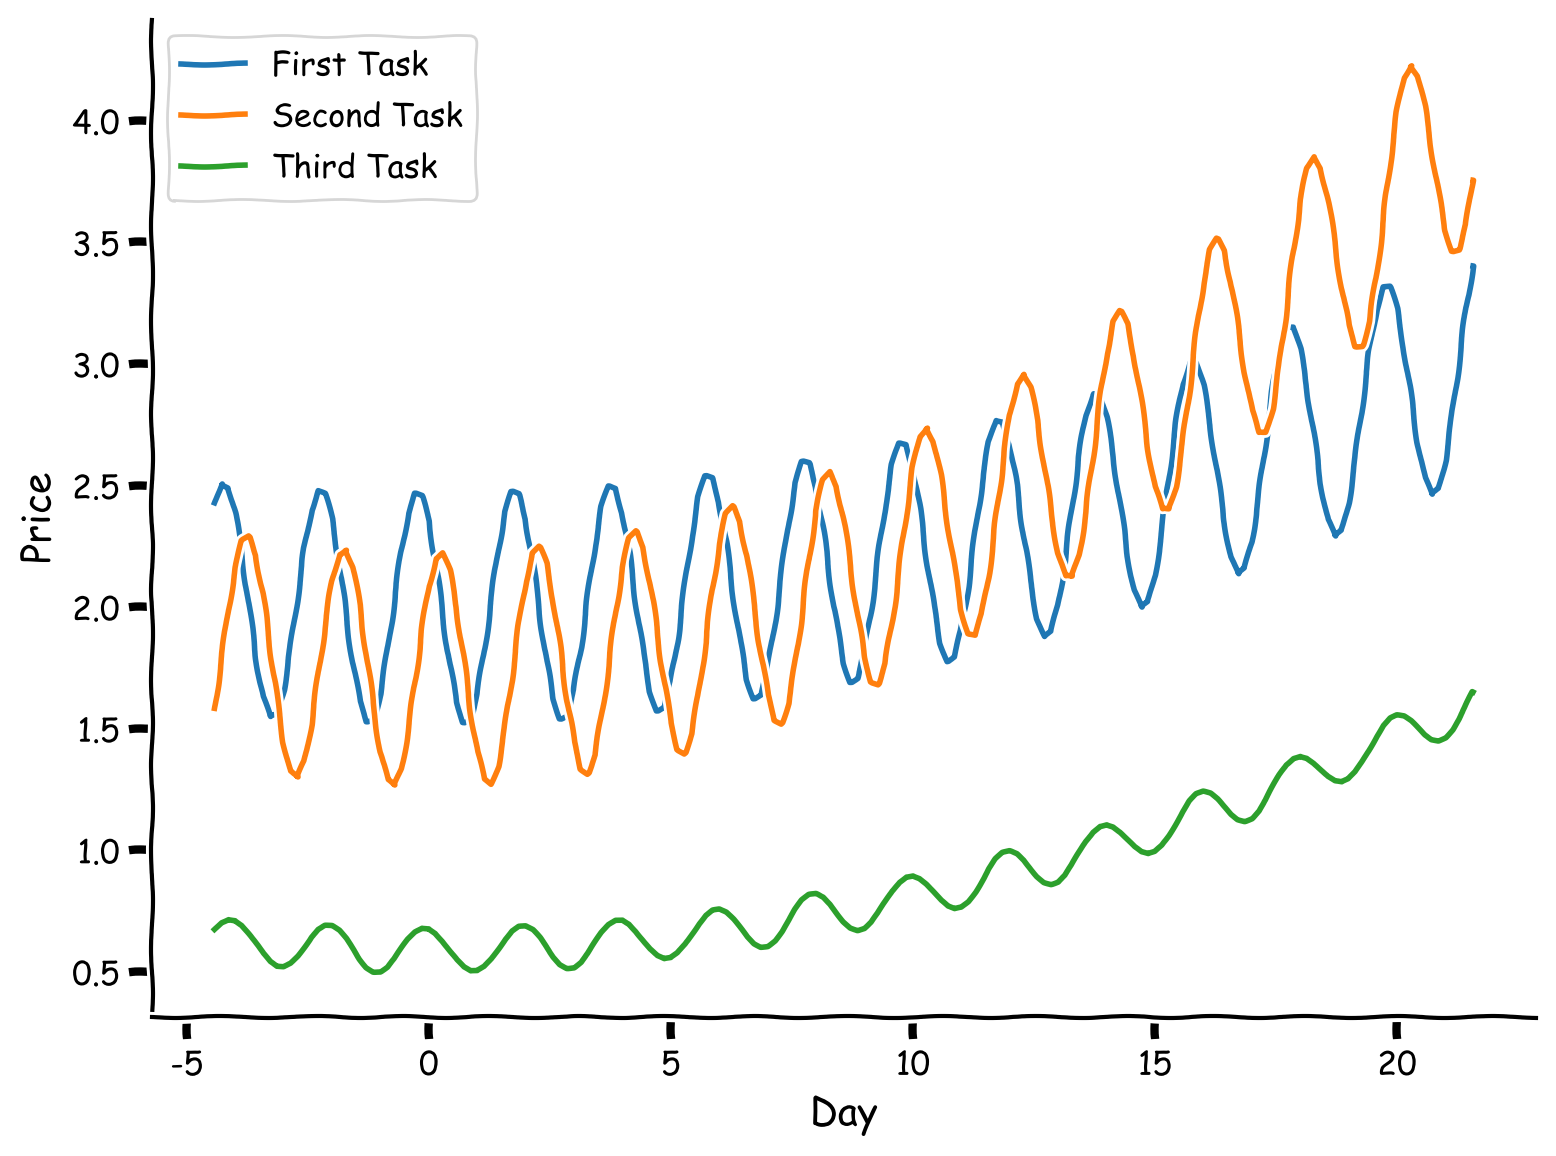

In [13]:
# @markdown Make sure you execute this cell to observe the plot!

#define dataset, dataloader & sample 3 tasks
set_seed(42)
example_fruit_dataset = FruitSupplyDataset(num_epochs = 1, num_samples = 183, num_tasks = 3, also_sample_outer = False) #183 because it equals the number of days in summer and autumn
example_fruit_dataloader = DataLoader(example_fruit_dataset, batch_size = 3)
task_days, task_prices = next(iter(example_fruit_dataloader))

#plot tasks
plot_tasks(task_days, task_prices)

### Coding Exercise 1 Discussion

1. Do you think these particular tasks are similar? Do you expect the model to learn their general nature?


In [14]:
#to_remove explanation

"""
Discussion: Do you think these particular tasks are similar? Do you expect the model to learn their general nature?

Though being pretty distinct visually, they share joint underlying dynamics - biweekly oscillation modeled by sinusoid and general increasing trend with the quadratic term; we expect the model to learn these patterns and to adapt quickly to the particular case.
""";

In [15]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_task_space")

---

# Section 2: Meta-training

*Estimated timing to here from start of tutorial: 20 minutes*

In this section we are ready to train the model to generalize well across the similar tasks. We will, at first, present the training procedure, discuss the intuition behind why it works and then we will complete code snippets to do our first meta-learning training.

## Coding Exercise 2: All about training

During meta-learning, a task $\tau_{i}$ is sampled from $p(\tau)$, the model is trained with $K$ samples this task and the loss $\mathcal{L}_{\tau_i}$ from $\tau_{i}$ (which will be MSE for these tasks) is calculated, and then tested on new samples from $\tau_{i}$. The model is then improved by considering how the test error on new data from $\tau_{i}$ changes with respect to its parameters. The proces can be described via the following pseudo-code:

$
\begin{align*}
& [1] \: \text{for new epoch do} \\
& [2] \: \quad\quad\text{Sample batch of tasks }\tau_i \sim p(\tau) \\
& [3] \: \quad\quad\text{for all }\tau_i \text{ do} \\
& [4] \: \quad\quad\quad\quad\text{Sample }K\text{ datapoints } \{x^{(j)}, y^{(j)}\}\text{ from }\tau_i \\
& [5] \: \quad\quad\quad\quad\text{Evaluate }\nabla_\theta \mathcal{L}_{\tau_i}(f_\theta) \\
& [6] \: \quad\quad\quad\quad\text{Compute adapted task-specific parameters with gradient descent:} \: \: \theta_i' = \theta - \alpha \nabla_\theta \mathcal{L}_{\tau_i}(f_\theta) \\
& [7] \: \quad\quad\quad\quad\text{Sample new datapoints }\{x^{(j)}, y^{(j)}\}\text{ from }\tau_i\text{ for the meta-update} \\
& [8] \: \quad\quad\text{end for} \\
& [9] \: \quad\quad\text{Update base parameters: }\theta \leftarrow \theta - \beta \nabla_\theta \sum_{\tau_i \sim p(\tau)} \mathcal{L}_{\tau_i}(f_{\theta_i'})\text{ using new sampled data and corresponding losses} \\
\end{align*}
$

At first, we sample a bunch of tasks for the new epoch (line $[2]$). Then, for each task (line $[3]$) we perform the same operations. Lines $[4] - [6]$ correspond to the so-called "inner" loop (and, thus, sampled data in $[4]$ is "inner") - we calculate new parameters of the model for the particular instance of the task $\tau_{i}$ by calculating gradient with respect to the defined loss function (line $[5]$) and calculating task-specific parameters by the step(s) of gradient descent (line $[6]$). Then, we perform "outer" loop and, thus, sample "outer" data from the very same tasks (as calculated for each $\tau_{i}$ in line $[7]$) and then update the base parameters of the model based on the performance of the task-specific models (line $[9]$, each task has its own inner parameters calculated in $[6]$; the loss is the sum of losses for all tasks in the epoch of training).

That's meta-learning in a nutshell! Now we are ready to complete meta-learning model functions. Let us discuss their main components to orient ourselves quickly as to what is going on under the hood:

- `inner_loop` - takes inner data (days and prices) from the particular instance of the task as input, calculates inner loss, gradient and performs calculation of parameters manually with one gradient descent step;
- `outer_loop` - takes outer data (days and prices) and calculated parameters for this particular task from `inner_loop` to calculate outer (meta) loss;
- `train_tasks` - iterates through all tasks in the epoch, performs inner and outer loops, accumulates meta loss from outer data and makes optimization of the model's base parameters.
  

Class `MetaLearningModel` is inherited from `UtilModel` which is defined in the very top of this notebook as it contains utility functions which are not of particular interest for us. For the outer loop, we use `Adam` optimizer initialized on the `model.parameters()` (the architecture of the model is the same as before - 2 hidden layers with 100 units in each; it is defined right after this code snippet), learning rate is defined in `UtilModel` as `outer_learning_rate`. Moreover, to calcuate loss for the outer loop based on the updated task-specific parameters, there is custom `manual_output` function in `UtilModel` which simply propagates through the architecture of MLP for given weights. For inner loop, there is `inner_learning_rate` for performing one gradient descent step.

Fill out the code below to calculate the loss and gradient updates for the inner loop.

In [16]:
class MetaLearningModel(UtilModel):
    def __init__(self, *args, **kwargs):
        """ Implementation of MAML (Finn et al. 2017).
        """
        super().__init__(*args, **kwargs)

        self.optimizer = optim.Adam(self.model.parameters(), lr = self.outer_learning_rate)

    def inner_loop(self, x_inner, y_inner):
        """ Compute parameters of the model in the inner loop but not update model parameters.
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: complete inner loop.")
        ################################################################### 
        #calculate loss for inner data
        loss = self.loss_fn(self.model(...), ...)

        #inner data gradients w.r.t calculated loss
        grads = torch.autograd.grad(..., self.model.parameters())

        #update weights based on inner data gradients; observe that we don't update `self.model.parameters()` here
        parameters = [parameter - self.inner_learning_rate * grad for parameter, grad in zip(self.model.parameters(), grads)]
        
        return parameters

    def outer_loop(self, x_outer, y_outer, weights):
        """ Compute loss for outer dats with already calculated parameters on inner data. 
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: complete outer loop.")
        ################################################################### 
        #observe that parameters come from inner data, while loss is calculated on outer one; it is the heart of meta-learning approach
        return self.loss_fn(self.manual_output(weights, ...), ...)

    def train_tasks(self, tasks):
        """ Utility method to train an entire epoch in one go. Implements the meta-update step for a batch of tasks.
        """
        #prepare for loss accumulation
        metaloss = 0
        self.optimizer.zero_grad()

        #take inner and outer data from dataset
        x_inner, y_inner, x_outer, y_outer = tasks
        
        #apply normalization on days
        x_inner = (x_inner - self.mean) / self.std
        x_outer = (x_outer - self.mean) / self.std

        #for each task there is going to be inner and outer loop
        for task_idx in range(x_inner.shape[0]):
            
            #find weights (line [6])
            parameters = self.inner_loop(x_inner[task_idx].type(torch.float32).to(device), y_inner[task_idx].type(torch.float32).to(device))

            #find meta loss w.r.t to found weights in inner loop (line [9])
            task_metaloss = self.outer_loop(x_outer[task_idx].type(torch.float32).to(device), y_outer[task_idx].type(torch.float32).to(device), parameters)

            #contribute to metaloss
            metaloss += task_metaloss

        #update model parameters
        metaloss.backward()
        self.optimizer.step()

        return metaloss.item() / x_inner.shape[0]

In [17]:
# to_remove solution

class MetaLearningModel(UtilModel):
    def __init__(self, *args, **kwargs):
        """ Implementation of MAML (Finn et al. 2017).
        """
        super().__init__(*args, **kwargs)

        self.optimizer = optim.Adam(self.model.parameters(), lr = self.outer_learning_rate)

    def inner_loop(self, x_inner, y_inner):
        """ Compute parameters of the model in the inner loop but not update model parameters.
        """
        #calculate loss for inner data
        loss = self.loss_fn(self.model(x_inner), y_inner)

        #inner data gradients w.r.t calculated loss
        grads = torch.autograd.grad(loss, self.model.parameters())

        #update weights based on inner data gradients; observe that we don't update `self.model.parameters()` here
        parameters = [parameter - self.inner_learning_rate * grad for parameter, grad in zip(self.model.parameters(), grads)]
        
        return parameters

    def outer_loop(self, x_outer, y_outer, weights):
        """ Compute loss for outer dats with already calculated parameters on inner data. 
        """
        #observe that parameters come from inner data, while loss is calculated on outer one; it is the heart of meta-learning approach
        return self.loss_fn(self.manual_output(weights, x_outer), y_outer)

    def train_tasks(self, tasks):
        """ Utility method to train an entire epoch in one go. Implements the meta-update step for a batch of tasks.
        """
        #prepare for loss accumulation
        metaloss = 0
        self.optimizer.zero_grad()

        #take inner and outer data from dataset
        x_inner, y_inner, x_outer, y_outer = tasks
        
        #apply normalization on days
        x_inner = (x_inner - self.mean) / self.std
        x_outer = (x_outer - self.mean) / self.std

        #for each task there is going to be inner and outer loop
        for task_idx in range(x_inner.shape[0]):
            
            #find weights (line [6])
            parameters = self.inner_loop(x_inner[task_idx].type(torch.float32).to(device), y_inner[task_idx].type(torch.float32).to(device))

            #find meta loss w.r.t to found weights in inner loop (line [9])
            task_metaloss = self.outer_loop(x_outer[task_idx].type(torch.float32).to(device), y_outer[task_idx].type(torch.float32).to(device), parameters)

            #contribute to metaloss
            metaloss += task_metaloss

        #update model parameters
        metaloss.backward()
        self.optimizer.step()

        return metaloss.item() / x_inner.shape[0]

In the function below we define the model architecture which is going to be passed as parameter to the `MetaLearningModel`.

In [18]:
class MLP(nn.Module):
    def __init__(self):
        """Defines model's architecture."""
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(100, 1)

    def forward(self, x):
        """Implements forward pass through defined layers of model."""
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.linear3(x)
        return x

Now that the classes and functions are built, we are ready to take a look at the `train` procedure. We first define an architecture, meta-learning model, dataset and dataloader. Then we iterate through the dataloader and call the `train_tasks` function on the new batch of tasks. For each 1000 epochs, we average the meta loss and output it. In the end of the training, we save the model parameters.

In [19]:
def train(name, num_epochs, num_tasks, num_samples):
    """Performs training for the meta-learning model."""
    
    model = MLP().to(device)
    meta_model = MetaLearningModel(model, mean = days_mean, std = days_std)

    fruit_dataset = FruitSupplyDataset(num_epochs = num_epochs + 1, num_tasks = num_tasks, num_samples = num_samples, also_sample_outer = True)
    fruit_dataloader = DataLoader(fruit_dataset, batch_size = num_tasks)

    epoch_loss = []

    for epoch in range(num_epochs + 1):
        tasks = next(iter(fruit_dataloader))
        mean_batch_loss = meta_model.train_tasks(tasks)
        epoch_loss.append(mean_batch_loss)
        
        if (epoch + 1) % 1000 == 0:
            print(
                f"Meta mean loss for epoch {(epoch + 1) // 1000}: {np.mean(epoch_loss[epoch - 999:epoch]):.03f}"
            )

    meta_model.save_parameters(name + '.pt')

To achieve the required level of performance, one should put `num_epochs` below to be equal to 100000, which would take the model at least 1 hour to train. Thus, in the start of the tutorial, we have presented you with the already trained model `SummerAutumnModel.pt`, make sure you can see it in the same folder as your tutorial notebook. 

Below, we perform training for 1000 epochs, so that you can still run your first meta-learning experiment and verify the correctness of the implementation!

In [20]:
set_seed(42)
meta_model_params = train("SummerAutumnModelTest", num_epochs = 1000, num_tasks = 30, num_samples = 40)

Meta mean loss for epoch 1: 0.123


You should be able to see that meta-loss value is $0.123$.

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_all_about_training")

## Think 2: Dreaming about a model

We suggest you use your imagination for a bit and visualize what you expect the base parameters of the model to have learned. When you load the pre-trained model, it will be in a state where it hasn't been exposed to any particular task. What would we expect its outputs to be in this state? Recall that the base parameters should somehow generalize the knowledge about the task family and still be robust for optimizing on new tasks.

Take 3 minutes to draw predictions on your own, then discuss your pictures in a group.

Then check it yourself right below this cell .

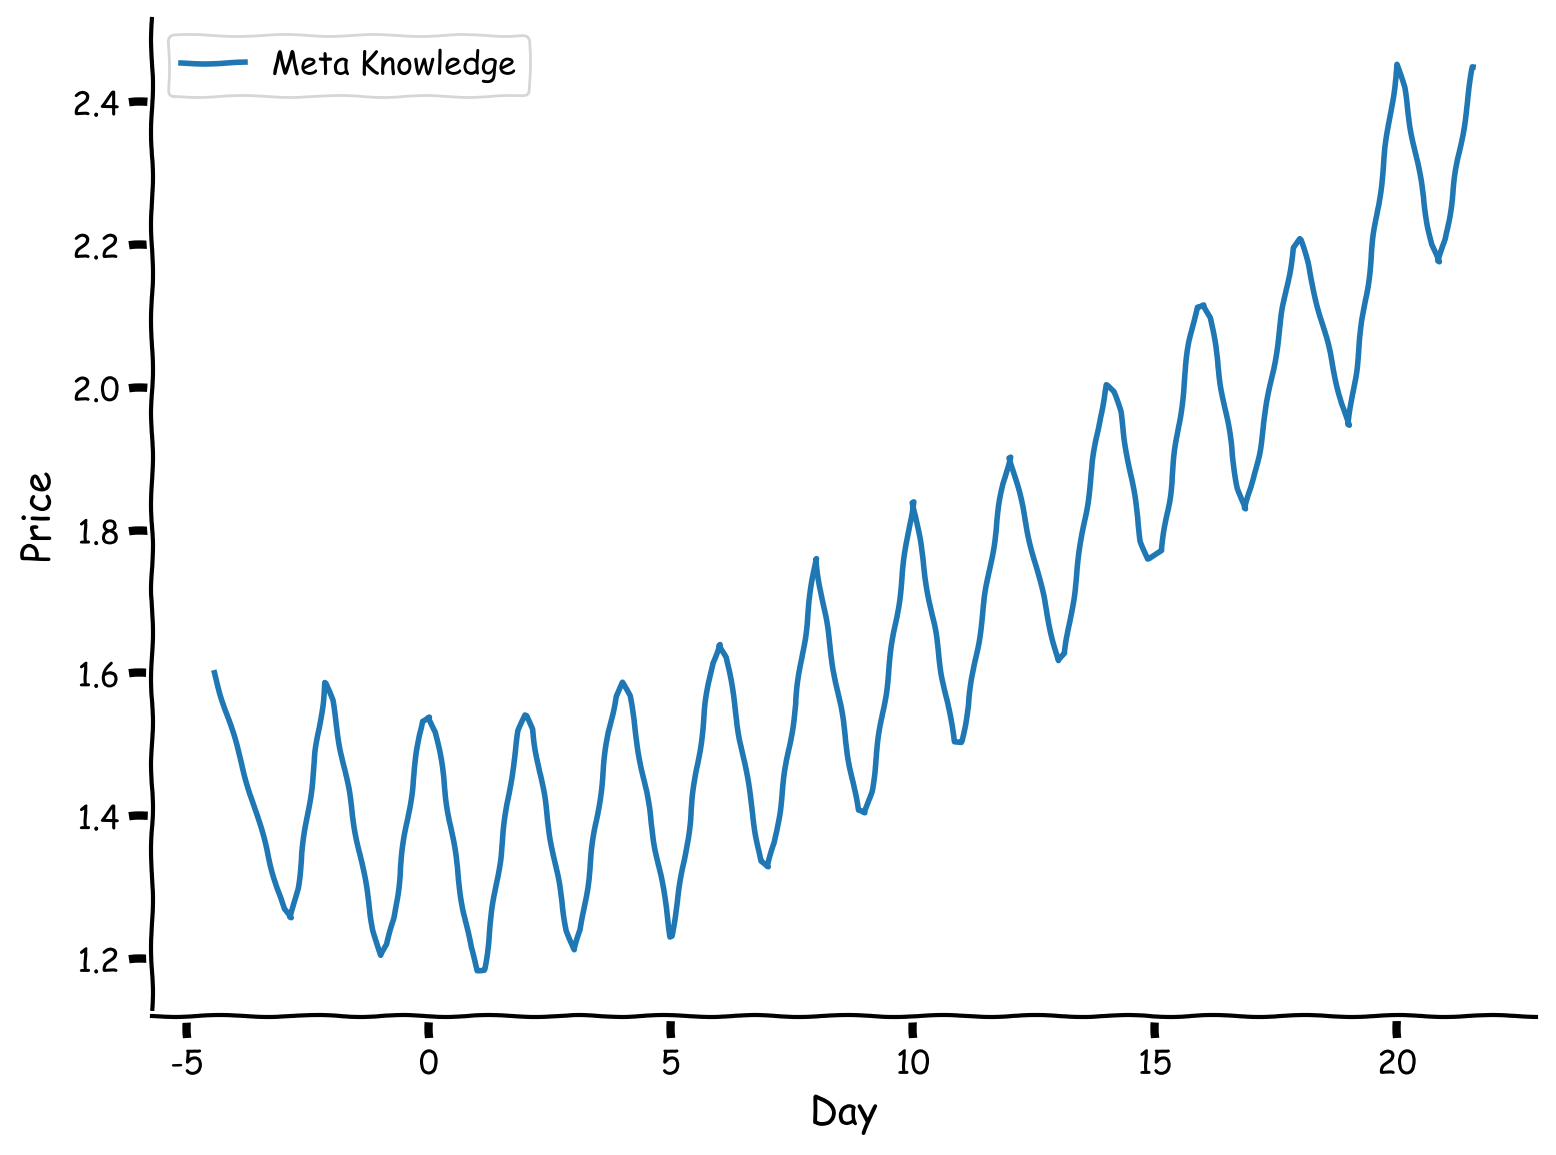

In [21]:
#make sure you have downloaded model in your files
model_path = 'SummerAutumnModel.pt'
meta_model = MetaLearningModel(model = model_path, mean = days_mean, std = days_std)
prediction = meta_model.inference(torch.tensor(np.expand_dims(days, 1)))

with plt.xkcd():
    plt.plot(days, prediction.detach().numpy(), label = "Meta Knowledge")
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Discuss:
Does the result match your drawings?

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_dream_about_model")

# Section 3: Adapt to a particular task

*Estimated timing to here from start of tutorial: 35 minutes*


## Coding Exercise 3: Fine-tuning model

Now, we would like to evaluate the learning ability of the meta-learned model by fine-tuning it to a particular task. For that, we clone model parameters and perform a couple of gradient descent steps on a small amount of the data for two specific facts:

$$A = 0.005, B = 0.1, \phi = 0, C = 1$$
$$A = -0.005, B = 0.1, \phi = 0, C = 4$$

Observe the second set of parameters. The model hasn't been exposed to negative values of $A$ in any of the tasks during training. We will see whether it has still learned enough for it to generalize well.

We will test this by completing the `finetune` function which takes `model`, data (`x_finetune`, `y_finetune`) sampled from the particular task ,and number of gradient descent steps to take (`finetune_gradient_steps`). We will use the Stochastic Gradient Descent optimizer to perform these steps on the cloned parameters, so that we preserve the meta-learnt ones.



In [51]:
def finetune(model, x_finetune, y_finetune, finetune_gradient_steps):
    """Take a fixed number of gradient steps for the given x_finetune and y_finetune.
    """
    #apply normalization on days
    x_finetune = (x_finetune - model.mean) / model.std

    #need to create clone, so that we preserve meta-learnt parameters
    clone = model.deep_clone_model(model.model)
    optimizer = optim.SGD(clone.parameters(), lr = model.inner_learning_rate)

    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete fine-tuning procedure.")
    ################################################################### 

    for _ in range(...):
        optimizer.zero_grad()
        loss = model.loss_fn(clone(...), ...)
        loss.backward()
        optimizer.step()

    return clone

In [22]:
# to_remove solution

def finetune(model, x_finetune, y_finetune, finetune_gradient_steps):
    """Take a fixed number of gradient steps for the given x_finetune and y_finetune.
    """
    #apply normalization on days
    x_finetune = (x_finetune - model.mean) / model.std

    #need to create clone, so that we preserve meta-learnt parameters
    clone = model.deep_clone_model(model.model)
    optimizer = optim.SGD(clone.parameters(), lr = model.inner_learning_rate)

    for _ in range(finetune_gradient_steps):
        optimizer.zero_grad()
        loss = model.loss_fn(clone(x_finetune), y_finetune)
        loss.backward()
        optimizer.step()

    return clone

Function `plot_performance` used below implements sampling and fine-tuning on sampled data under the hood as well as predicting for all days after that. 

In [23]:
def plot_performance(task, meta_model, gradient_steps, num_samples_finetune):
    """
    Plot the predictions of prices on fine-tuned model.

    Inputs:
    - task (list): Parameters of the task to be sample from.
    - meta_model (MetaLearningModel): An instance of meta-learning model initialized from the parameters file and over which fine-tuning will take place.
    - gradient_steps (int): number of steps to perform gradient descent.
    - num_samples_finetune (int) number of samples.
    """

    #sample data from the desired task
    dataset = FruitSupplyDataset(also_sample_outer = False)
    x_finetune, y_finetune = dataset.sample_particular_task(*task, num_samples_finetune)    

    with plt.xkcd():
      prices = task[0] * days ** 2 + task[1] * np.sin(np.pi * days + task[2]) + task[3]
      plt.plot(days, prices, label = "True function")

      #we finetune on sampled (x_finetune, y_finetune) but calculate predictions on all days
      prediction = finetune(meta_model, torch.tensor(x_finetune).type(torch.float32).to(device),  torch.tensor(y_finetune).type(torch.float32).to(device), gradient_steps)(torch.tensor((np.expand_dims(days, 1) - days_mean) / days_std).type(torch.float32).to(device)).detach().numpy()

      print(f"R-squared value is {r2_score(prices, prediction):.02f}")
        
      plt.plot(days, prediction, label=f'{gradient_steps} gradient steps')
      plt.title(f'Fine-tuned model on {num_samples_finetune} samples')
      plt.xlabel('Day')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

def visualize(name, gradient_steps, num_samples_finetune):
    """Performs fine-tuning for a couple of tasks in a row.

    Inputs:
    - name (str): Name of the model's file.
    - gradient_steps (int): number of steps to perform gradient descent.
    - num_samples_finetune (int) number of samples.
    """
    
    model_path = name + '.pt'
    meta_model = MetaLearningModel(model = model_path, mean = days_mean, std = days_std)

    tasks = [[0.005, 0.1, 0.0, 1.0], [-0.005, 0.1, 0.0, 4.0]]

    for task in tasks:
        fig = plot_performance(task, meta_model, gradient_steps, num_samples_finetune)

R-squared value is 0.96


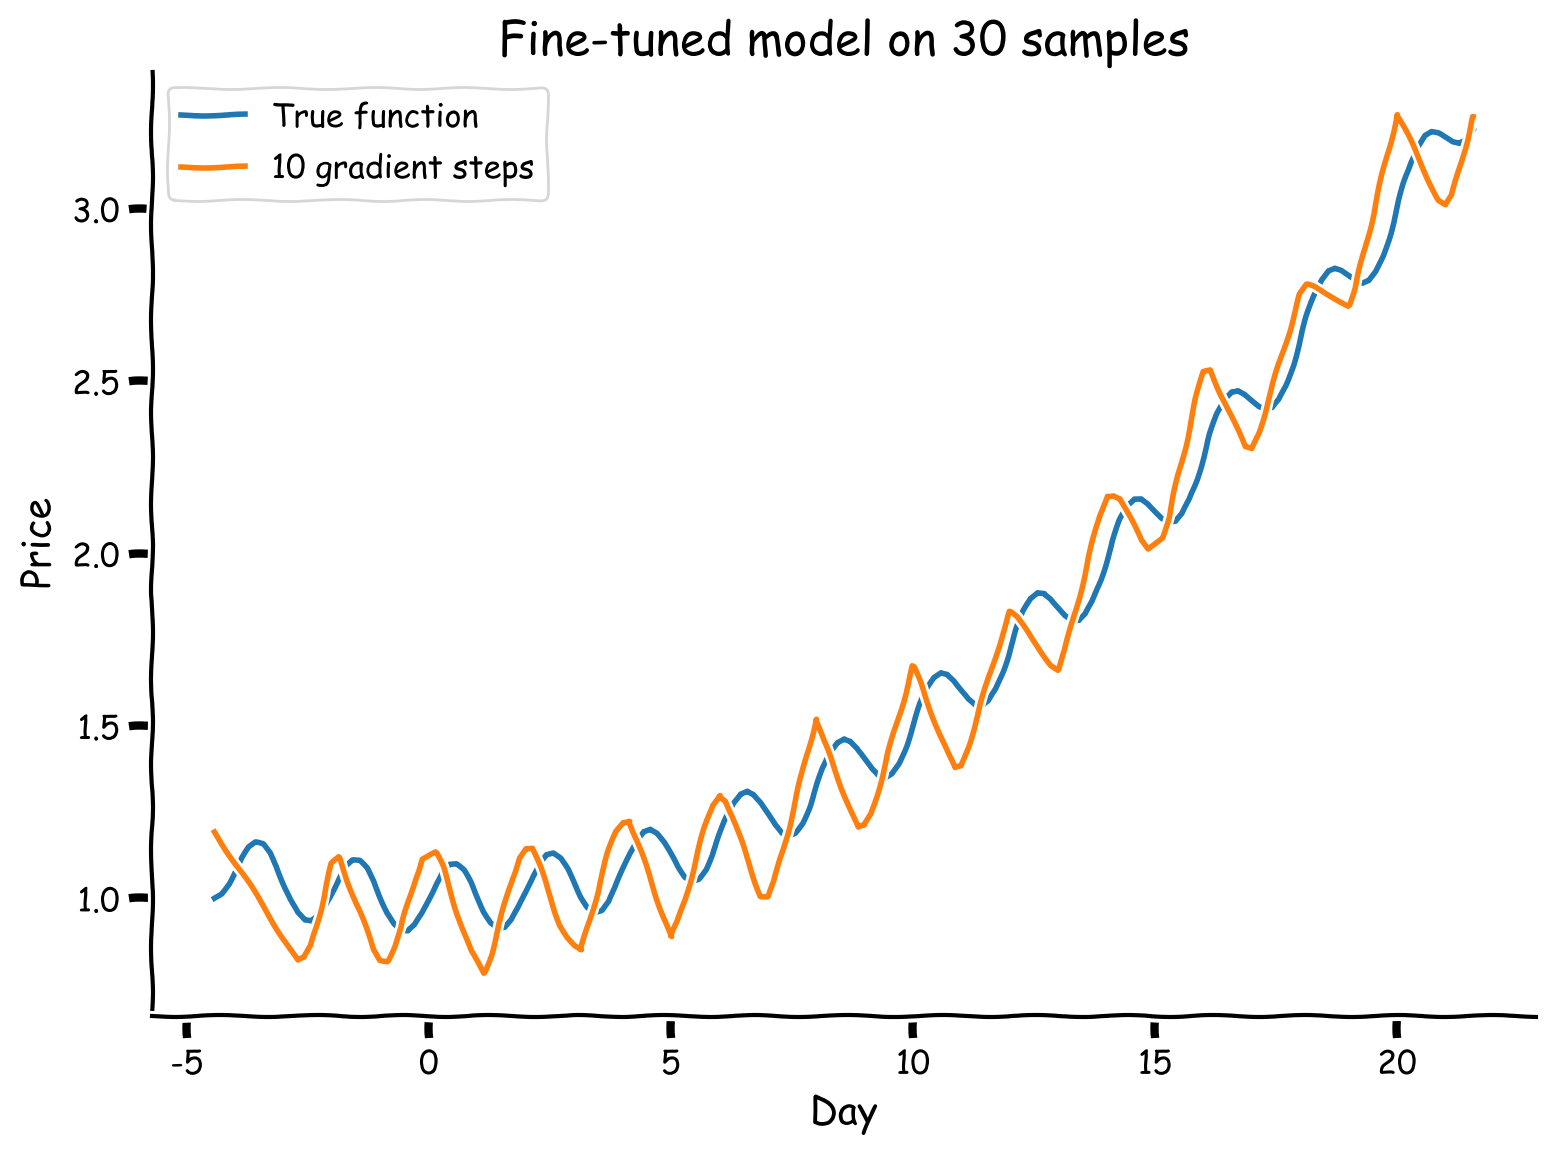

R-squared value is 0.91


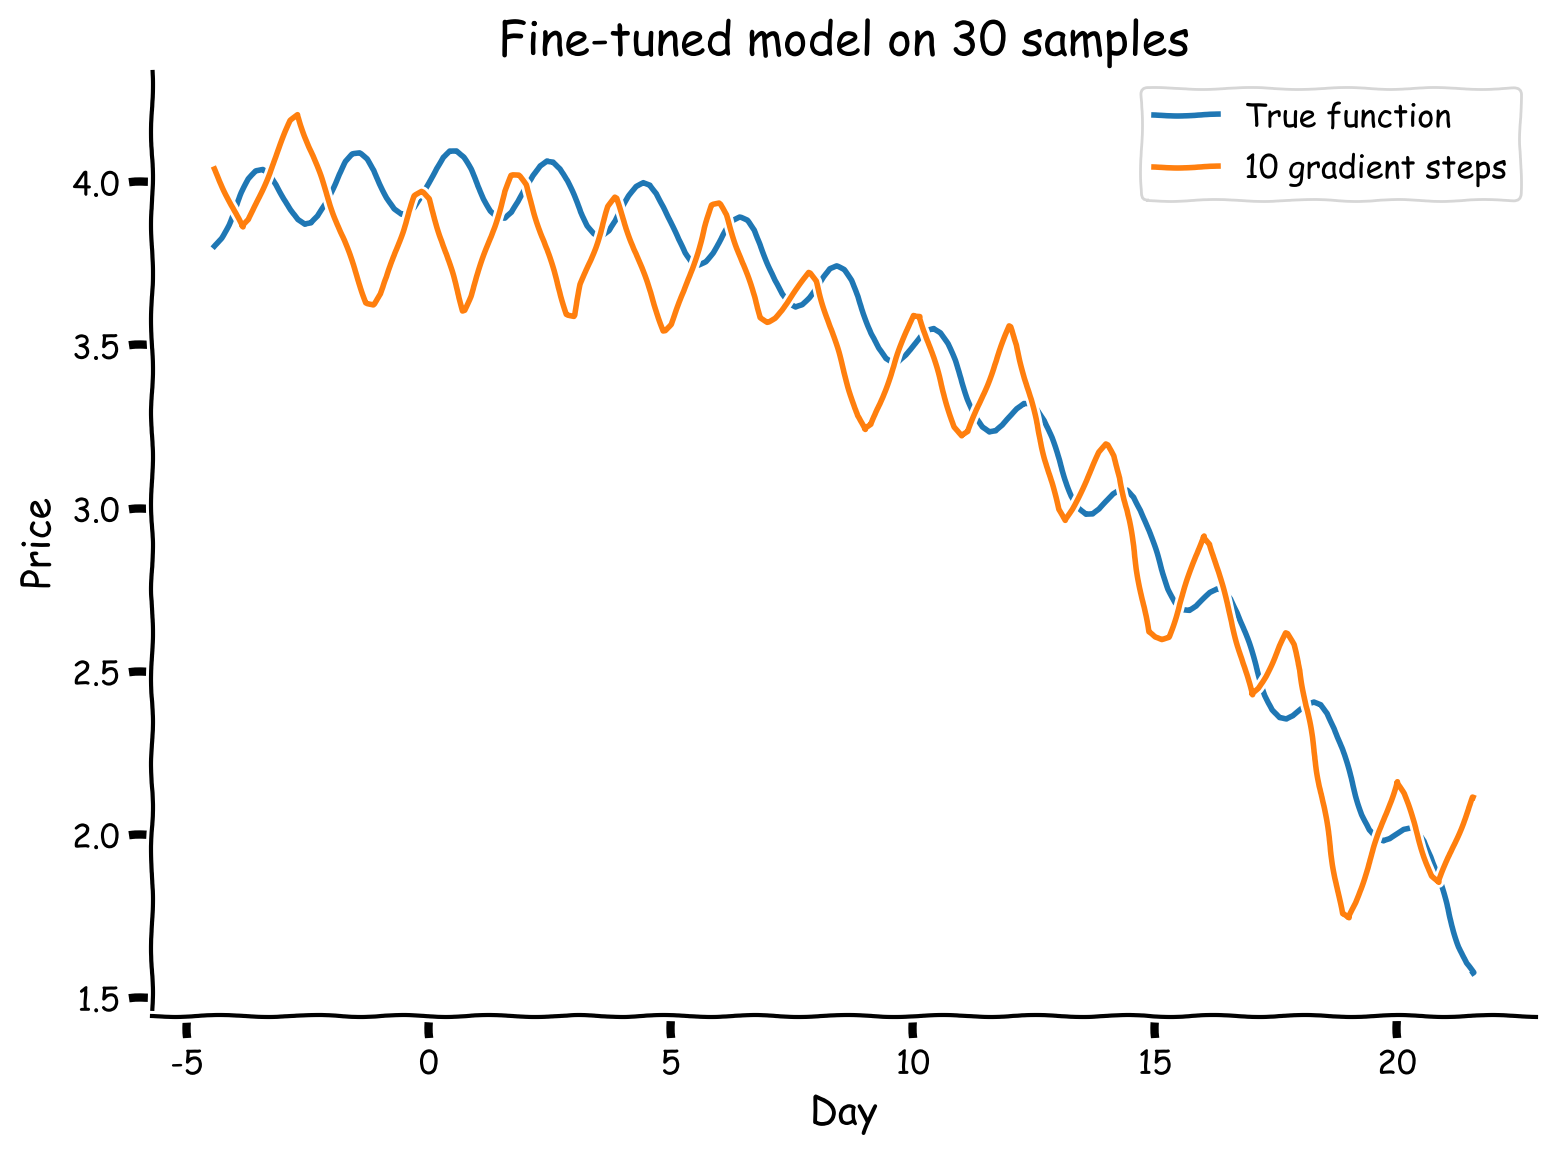

In [24]:
set_seed(42)
visualize("SummerAutumnModel", gradient_steps = 10, num_samples_finetune = 30)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_finetuning_model")

## Interactive Demo 3: Number of data points & gradient steps

We've seen how the meta-learning procedure created a model that could quickly adapt to new tasks (including the inverted curve!). In the above examples we used 30 samples from each task and 10 gradient steps. In this interactive demo we invite you to explore what is the reasonable amount of data points to sample from particular task, as well as the number of gradient steps to make, to finetune model's performance.

What is the relationship between these 2 parameters of finetuning parameters? Have you noticed any bottom bound for any of the parameters such that below these thresholds the performance can't be expected to be great?

In [25]:
# @markdown Make sure you execute this cell to observe the widget!

set_seed(42)

@widgets.interact
def interactive_visualize(
    gradient_steps = widgets.IntSlider(description="Gradient Steps", min=0, max=20, step=1, value=10), num_samples =  widgets.IntSlider(description="Samples", min=5, max=150, step=5, value=100)):
    visualize("SummerAutumnModel", gradient_steps, num_samples)

interactive(children=(IntSlider(value=10, description='Gradient Steps', max=20), IntSlider(value=100, descript…

In [26]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_number_of_data_points_and_gradient_steps)

---
# Summary

*Estimated timing of tutorial: 50 minutes*

Have a summary of what we've learned

1. Meta-learning aims to create a model that can quick learn any task from a distribution

2. To do this, it uses inner and outer learning loops to find base parameters from which a small number of gradient steps can lead to good preformance on any task